# Modeling and Evaluation - Predict House Price

## Objectives

* Fit and evaluate a classification model to predict a house sale price when the house features are known.

## Inputs
* outputs/datasets/collection/HousePricesRecords.csv
* Feature engineering/data cleaning from the feature engineering notebook.

## Outputs 
* Train set
* Test set
* ML pipeline to predict house sale prices



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-ML-PROJECT/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-ML-PROJECT'

# Load Data

In [4]:
import pandas as pd
import numpy as np
df = (pd.read_csv("outputs/datasets/collection/housing_data_cleaned.csv"))
df.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,1,706.0,6.0,150.0,548.0,2.0,2003.0,...,8450.0,65.0,196.0,61.0,5,7,856.0,2003,2003,208500.0
1,1262.0,0.0,3.0,4,978.0,5.0,284.0,460.0,2.0,1976.0,...,9600.0,80.0,0.0,0.0,8,6,1262.0,1976,1976,181500.0
2,920.0,866.0,3.0,2,486.0,6.0,434.0,608.0,2.0,2001.0,...,11250.0,68.0,162.0,42.0,5,7,920.0,2001,2002,223500.0
3,961.0,0.0,3.0,1,216.0,5.0,540.0,642.0,1.0,1998.0,...,9550.0,60.0,0.0,35.0,5,7,756.0,1915,1970,140000.0
4,1145.0,0.0,4.0,3,655.0,6.0,490.0,836.0,2.0,2000.0,...,14260.0,84.0,350.0,84.0,5,8,1145.0,2000,2000,250000.0
5,796.0,566.0,1.0,1,732.0,6.0,64.0,480.0,1.0,1993.0,...,14115.0,85.0,0.0,30.0,5,5,796.0,1993,1995,143000.0
6,1694.0,0.0,3.0,3,1369.0,6.0,317.0,636.0,2.0,2004.0,...,10084.0,75.0,186.0,57.0,5,8,1686.0,2004,2005,307000.0
7,1107.0,983.0,3.0,2,859.0,5.0,216.0,484.0,2.0,1973.0,...,10382.0,69.0,240.0,204.0,6,7,1107.0,1973,1973,200000.0
8,1022.0,752.0,2.0,1,0.0,1.0,952.0,468.0,1.0,1931.0,...,6120.0,51.0,0.0,0.0,5,7,952.0,1931,1950,129900.0
9,1077.0,0.0,2.0,1,851.0,6.0,140.0,205.0,2.0,1939.0,...,7420.0,50.0,0.0,4.0,6,5,991.0,1939,1950,118000.0


## Create ML Pipeline

## ML pipeline for data cleaning and feature engineering

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
# Taken from data cleaning notebook
class MyCustomEncoder(BaseEstimator, TransformerMixin):

  def __init__(self, variables, dic):
    if not isinstance(variables, list): 
      self.variables = [variables]
    else: self.variables = variables
    self.dic = dic

  def fit(self, X, y=None):    
    return self

  def transform(self, X):
    for col in self.variables:
      if X[col].dtype == 'object':
        X[col] = X[col].replace(dic[col])
      else:
        print(f"Warning: {col} data type should be object to use MyCustomEncoder()")
      
    return X

- **Import all necassary ML algorithms**

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

### Bring in the pipeline from the feature engineering notebook with feature scaling, feature selection and model added:

In [7]:
def PipelineOptimization(dic, vars_with_missing_data, model):
    
      pipeline = Pipeline([
            # ('drop_features', DropFeatures(features_to_drop = ['EnclosedPorch', 'WoodDeckSF'])),    
            ('custom_encoder', MyCustomEncoder(variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], dic=dic)),        
            ('median_imputer',  MeanMedianImputer(imputation_method='median', variables=vars_with_missing_data)),
            ('corr_sel', SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")),
            ("feat_scaling", StandardScaler() ),
            ("feat_selection",  SelectFromModel(model) ),
            ("model", model ),
      ])

      return pipeline    


- **Hyperparameter optimization**: Custom hyperparameter optimization to fit my model

In [8]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, dic, vars_with_missing_data, models, params):
        self.dic = dic
        self.vars_with_missing_data = vars_with_missing_data
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(dic, vars_with_missing_data, self.models[key],)

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split the data into Train and Test sets

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print('Train Set:', X_train.shape, y_train.shape, 'Test Set:', X_test.shape, y_test.shape)

Train Set: (1168, 21) (1168,) Test Set: (292, 21) (292,)


Visualise the difference in train and test set data

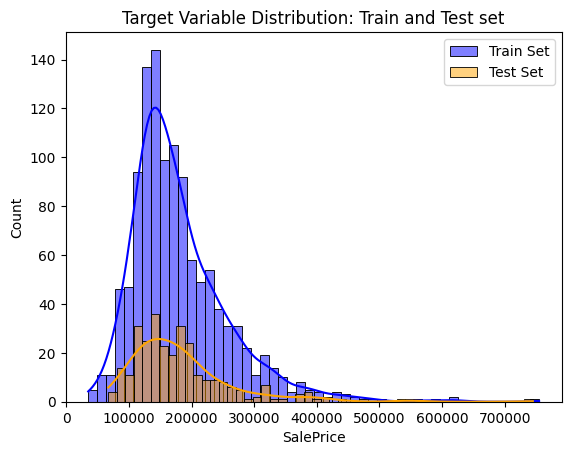

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_train, kde=True, bins=50, color='blue', label='Train Set')
sns.histplot(y_test, kde=True, bins=50, color='orange', label='Test Set')
plt.legend()
plt.title("Target Variable Distribution: Train and Test set")
plt.show()


## Grid Search CV from Scikit Learn

Lets try 7 ML models to find the best one

In [11]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [12]:
dic = {'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}, 'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}, 'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}, 'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}}

# Variables with missing variables after dropping ['EnclosedPorch', 'WoodDeckSF']. This is a parameter passed to MeanMedianImputer
vars_with_missing_data = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea']   

In [13]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_

/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
